In [1]:
import os, sys
from pathlib import Path

nb_dir = Path.cwd()
repo_root = nb_dir.parent
sys.path.insert(0, str(repo_root))

print("Notebook dir:", nb_dir)
print("Repo root:", repo_root)

Notebook dir: h:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\notebooks
Repo root: h:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from src.geo_constraints import DataPaths
from src.dataset_vie import StanfordVIEWellPatchDataset

DATA_ROOT = r"H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data"
paths = DataPaths(DATA_ROOT)

constraints_npz = os.path.join(paths.processed_dir, "constraints.npz")
print("constraints:", constraints_npz)

ds = StanfordVIEWellPatchDataset(
    paths=paths,
    constraints_npz=constraints_npz,
    patch_hw=4,           # 9x9 patch
    use_masked_y=True,
    normalize=True
)
print("N samples (wells):", len(ds))

constraints: H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data\processed\constraints.npz
N samples (wells): 300


In [3]:
batch = ds[0]
for k in ["x","p","c","m","y","il","xl","wellname"]:
    v = batch[k]
    if isinstance(v, torch.Tensor):
        print(k, tuple(v.shape), v.dtype)
    else:
        print(k, v)

x (1, 9, 9, 200) torch.float32
p (4, 9, 9, 200) torch.float32
c (1, 9, 9, 200) torch.float32
m (1, 9, 9, 200) torch.float32
y (200,) torch.float32
il () torch.int32
xl () torch.int32
wellname VW0001


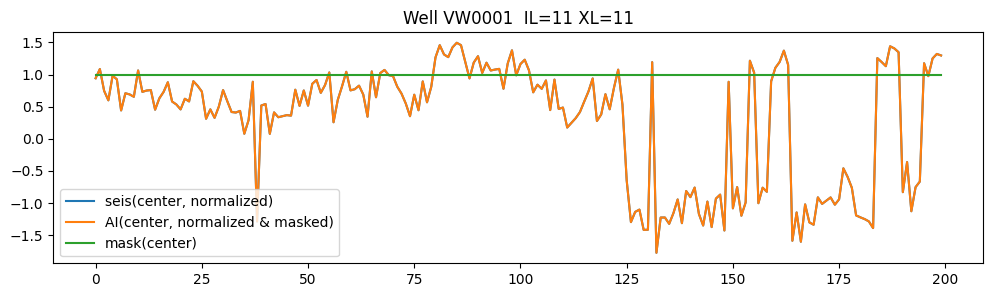

In [4]:
x = batch["x"].numpy()   # [1,H,W,T]
m = batch["m"].numpy()   # [1,H,W,T]
y = batch["y"].numpy()   # [T]

H, W = x.shape[1], x.shape[2]
cx, cy = H//2, W//2

seis_center = x[0, cx, cy, :]
mask_center = m[0, cx, cy, :]

plt.figure(figsize=(12,3))
plt.plot(seis_center, label="seis(center, normalized)")
plt.plot(y, label="AI(center, normalized & masked)")
plt.plot(mask_center, label="mask(center)")
plt.legend()
plt.title(f"Well {batch['wellname']}  IL={int(batch['il'])} XL={int(batch['xl'])}")
plt.show()

In [5]:
import os
import random
import numpy as np

seed = 2026
random.seed(seed)
np.random.seed(seed)

N = len(ds)
idxs = list(range(N))
random.shuffle(idxs)

# =========================
# 比例设置
# =========================
train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

n_train = int(train_ratio * N)
n_val   = int(val_ratio * N)

train_idx = idxs[:n_train]
val_idx   = idxs[n_train:n_train + n_val]
test_idx  = idxs[n_train + n_val:]

print(f"Total: {N}")
print(f"Train: {len(train_idx)}")
print(f"Val  : {len(val_idx)}")
print(f"Test : {len(test_idx)}")

# =========================
# 保存
# =========================
split_dir = os.path.join(paths.processed_dir, "splits")
os.makedirs(split_dir, exist_ok=True)

np.save(os.path.join(split_dir, "train_idx.npy"),
        np.array(train_idx, dtype=np.int32))
np.save(os.path.join(split_dir, "val_idx.npy"),
        np.array(val_idx, dtype=np.int32))
np.save(os.path.join(split_dir, "test_idx.npy"),
        np.array(test_idx, dtype=np.int32))

print("Saved splits to:", split_dir)

Total: 300
Train: 210
Val  : 45
Test : 45
Saved splits to: H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data\processed\splits
